In [22]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1
%env VECLIB_MAXIMUM_THREADS=1

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1
env: VECLIB_MAXIMUM_THREADS=1


In [23]:
from wgan.imblearn import GANbalancer

In [24]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN

from functools import partial
from lift.perc_lift_score import perc_lift_score

In [25]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=4000, n_features=20, weights=[0.95,0.05], 
                          n_informative=20, n_redundant=0, n_clusters_per_class=1)
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)
#idx_cont = list(range(20))
#categorical = None

In [29]:
no_cont = 15
ct = ColumnTransformer([
    ("scaler", MinMaxScaler(), slice(0,no_cont)),
    ("discretizer", KBinsDiscretizer(n_bins=5, encode='ordinal', strategy="quantile"),
     slice(no_cont,20))
], remainder="drop")
X = ct.fit_transform(X)

idx_cat = list(range(no_cont,20))
idx_cont = list(range(no_cont))
categorical = [(i, 5, 3) for i in range(no_cont,20)]

In [27]:
gan = GANbalancer(idx_cont=idx_cont, categorical=categorical, sampling_strategy='auto',#{0:0,1:900},
                 generator_input=100, generator_layers=[100,100], critic_layers=[100], 
                  n_iter=100000, critic_iterations=2, verbose=1, learning_rate=(10e-3,10e-3),
                 auxiliary = True)

In [6]:
gan._fit(X,y)

6it [00:25,  4.18s/it]               


GANbalancer(auxiliary=True, batch_size=64,
      categorical=[(15, 5, 3), (16, 5, 3), (17, 5, 3), (18, 5, 3), (19, 5, 3)],
      critic_iterations=2, critic_layers=[100], generator_input=100,
      generator_layers=[100, 100, 100],
      idx_cont=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
      learning_rate=(0.01, 0.01), n_iter=1, random_state=None,
      sampling_strategy='auto', verbose=1)

In [ ]:
gan.sampling_strategy_

In [ ]:
(np.sum(y), np.sum(-y+1))

In [ ]:
gan.sampling_strategy_ = {0:3780,1:220}

In [ ]:
gan.generator.sample_data(n_samples, class_sample).shape

In [ ]:
gan.generator.sample_output_dim

In [7]:
#X_new, y_new = gan.fit_resample(X,y)
X_new, y_new = gan.fit_resample(X,y)

100004it [42:55, 36.54it/s]                           


In [8]:
gan.generator.training_iterations

100004

In [9]:
X.shape

(4000, 20)

In [10]:
np.sum(y)

224

In [11]:
X_new.shape

(7552, 20)

In [12]:
np.sum(y_new)

3776.0

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
logit1 = LogisticRegression().fit(X,y)
logit2 = LogisticRegression().fit(X_new, y_new)

/home/RDC/hauptjoh.hub/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/RDC/hauptjoh.hub/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
(roc_auc_score(y, logit1.predict_proba(X)[:,1]),
 roc_auc_score(y, logit2.predict_proba(X)[:,1]))

(0.9347760290556901, 0.9327153166616222)

In [205]:
X[y==0,:].mean(axis=0)

array([0.48781312, 0.49597541, 0.47556518, 0.50464357, 0.48554259,
       0.52836438, 0.49910371, 0.46033013, 0.47676461, 0.49288087,
       0.45779924, 0.496846  , 0.49759343, 0.40910822, 0.50892458,
       1.96269841, 1.9952381 , 1.99920635, 2.0037037 , 2.0005291 ])

In [206]:
X_new[y_new==0,:].mean(axis=0)

array([0.50991524, 0.59038986, 0.51001798, 0.49626015, 0.4311306 ,
       0.58158381, 0.47845855, 0.4050635 , 0.49684546, 0.44209386,
       0.4012649 , 0.51067111, 0.45579074, 0.4038544 , 0.45874551,
       1.86137566, 2.18730159, 1.92195767, 1.87116402, 2.14365079])

In [207]:
X[y==1,:].mean(axis=0)

array([0.58423031, 0.61629643, 0.46219021, 0.52091803, 0.38543816,
       0.4361234 , 0.50301084, 0.3803436 , 0.39131709, 0.40991746,
       0.46008503, 0.39367746, 0.50290332, 0.5238262 , 0.59520596,
       2.64090909, 2.08181818, 2.01363636, 1.93636364, 1.99090909])

In [208]:
X_new[y_new==1,:].mean(axis=0)

array([0.51241798, 0.56463272, 0.4959484 , 0.49001128, 0.45593831,
       0.53839977, 0.45925621, 0.4340501 , 0.45866682, 0.47784664,
       0.43078607, 0.5012189 , 0.49005134, 0.39861251, 0.48524152,
       1.93636364, 2.13636364, 2.18636364, 1.92272727, 2.09545455])

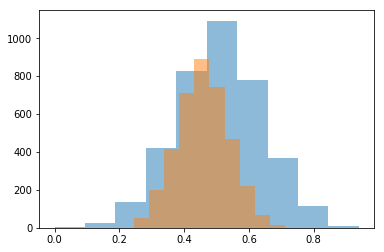

In [220]:
import matplotlib.pyplot as plt
plt.hist(X[y==0,14], alpha=0.5)
plt.hist(X_new[y_new==0,14],alpha=0.5)
plt.show()